In [1]:
using DataFrames
using StatsBase
using Distributions
using Random
using NeutralLandscapes # There's an incompatability compiling this with another package, but the ones here aren't it
using PkgCite
using Plots; pgfplotsx()
using Counters
using ProgressMeter
using CSV

In [2]:
#=
# read Burlington raster 
Buland = geoarray("BurlingtonLandCover2016.gri")
# this raster is ~25km in width

# Get rid of 3rd dim
Buland_array = collect(convert(Array{Float64}, Buland)[:,:,1])

# Check for rows of all NaN
na_sums = sum(convert(Array{Float64}, isnan.(Buland_array)),dims=1)

na_sums[na_sums .== size(Buland_array,2)] #all rows have meaningful values; proceed

# Get percentages of each land cover type
c = Counter{Float64}()
incr!(c, Buland_array)

land_proportions = [c[unique(Buland_array)[i]]/sum(c) for i in 1:length(unique(Buland_array))]
#append!(land_proportions, 0)

Values from National Land Cover Database
41 = Forest
21 = Developed
81 = Pasture
90 = wetlands
71 = herbaceous
82 = cultivated crops
31 = barren
52 = shrub/scrub
=#


land_proportions =  [0.29950784172189776, 0.22446136010674367, 0.2523743902705777, 0.1341207865782969, 0.06295251219458844, 
                        0.003442920576590765, 0.018693265087385436, 0.0023557976245160445, 0.0020911258394032853, 0.0, 0.0]

hab_names = ["forest", "developed", "pasture", "wetlands", "herbaceous", "cultivated", "barren", "shrub", "barrier", "buffer"]
hab_coefs = [0.12, -0.5, -0.03, 0.57, 0, -0.5, 0, 0.4, 0, -0.5]
hab_frame = DataFrame(type = hab_names, prop = land_proportions[2:11], coef = hab_coefs)


,type,prop,coef
,String,Float64,Float64
1,forest,0.224461,0.12
2,developed,0.252374,-0.5
3,pasture,0.134121,-0.03
4,wetlands,0.0629525,0.57
5,herbaceous,0.00344292,0.0
6,cultivated,0.0186933,-0.5
7,barren,0.0023558,0.0
8,shrub,0.00209113,0.4
9,barrier,0.0,0.0


In [ ]:
# Create simulated landscapes
function initialize_land(;land_size = 60, barrier_strength=0)
    # 1 cell = 0.5 km by 0.5 km
    # 5-cell buffer in outputs

    # Create neutral landscape based on real habitat proportions
    #clustered_land = rand(NearestNeighborCluster(0.2), (land_size, land_size))
    clustered_land = rand(NeutralLandscapes.MidpointDisplacement(0.758), (land_size, land_size))

    landscape = NeutralLandscapes.classify(clustered_land, land_proportions[2:10])

    # Add buffer habitat
    landscape[1:5,:] .= 10
    landscape[56:60,:] .= 10
    landscape[:,1:5] .= 10
    landscape[:,56:60] .= 10

    #=
    # Create barrier if one exists
    if barrier_strength != 0
        # Pick starting and ending edges for barrier
        edges = ["north", "south", "east", "west"]
        barrier1edge = sample(edges, 2, replace=false)
        barrier2edge = sample(edges, 2, replace=false)

        function create_coord(x)
            y=Vector(undef, 2)

            if x == "north"
                y[1] = rand(1:land_size)
                y[2] = land_size
            elseif x == "east"
                y[1] = land_size
                y[2] = rand(1:land_size)
            elseif x == "south"
                y[1] = rand(1:land_size)
                y[2] = 1
            else 
                y[1] = 1
                y[2] = rand(1:land_size)
            end

            return y
        end
        
        # Start & end coords for barrier
        barrier1start = create_coord(barrier1edge[1])
        barrier1end = create_coord(barrier1edge[2])

        barrier2start = create_coord(barrier2edge[1])
        barrier2end = create_coord(barrier2edge[2])
        
        # Create barriers by calculating slope and intercept from the coords
        function add_barriers(startcoords, endcoords)
            # Calculate slope of barrier line
            if (startcoords[1] - endcoords[1]) == 0
                slope = "undefined"
            else
                slope = (startcoords[2]-endcoords[2])/(startcoords[1]-endcoords[1])
            end

            # Intercept of barrier
            if slope != "undefined"
                intercept = startcoords[2] - slope*startcoords[1]
                # Get the cells the barrier falls on
                x = collect(range(start=minimum([startcoords[1], endcoords[1]]), stop=maximum([startcoords[1],endcoords[1]]), step=0.1))
                y = (slope .* x) .+ intercept
                barrier = DataFrame(x = Int.(round.(x)), y = Int.(round.(y)))
                barrier = unique(barrier)
            else
                x = fill(startcoords[1], land_size)
                y = collect(range(start=1, stop=land_size, step=1))

                barrier = DataFrame(x = x[i][i], y = y)
            end

            return(barrier)
        end

        # Build the barrier
        barrier1 = add_barriers(barrier1start, barrier1end)
        barrier2 = add_barriers(barrier2start, barrier2end)
        
        landscape[CartesianIndex.(barrier1.x, barrier1.y)] .= 9.0
        landscape[CartesianIndex.(barrier2.x, barrier2.y)] .= 9.0
        
        # Define barrier strength
        barrier_stren = [1,2,3,4]
        barrier_coefs = [-0.25, -0.5, -1, -10]

        barrier_frame = DataFrame(strength=barrier_stren, coef = barrier_coefs)
        barrier_index = findall(x-> x == barrier_strength, barrier_frame.strength)
        coef = barrier_frame.coef[barrier_index]

        habitats[9,:] = ["barrier", 0.0, coef[1]]
    end
=#
    return landscape
end

initialize_land (generic function with 1 method)



MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation


MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation


MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation


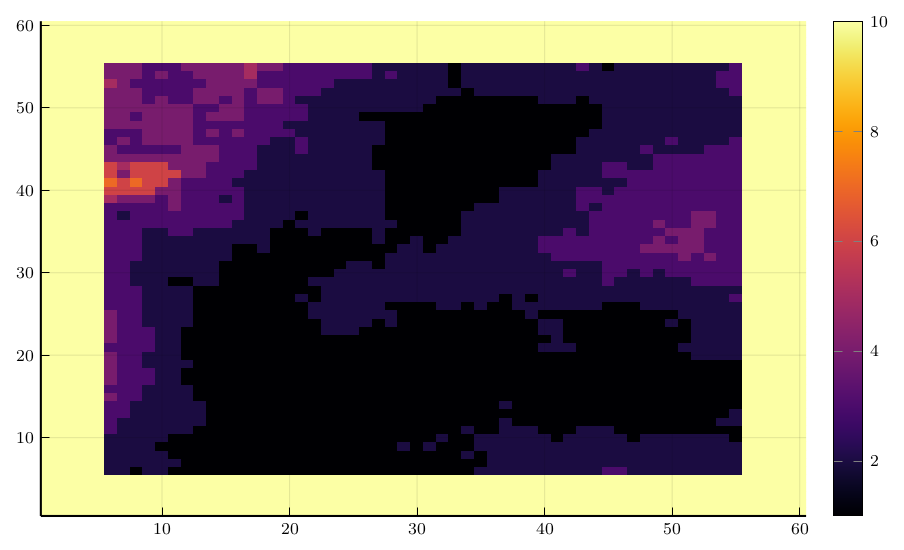

In [11]:
land = initialize_land()
heatmap(land)

In [5]:
function populate_landscape(;land_size = 60, guy_density = 2.75, seros)
    # Define main area of simulation
    xmin = 6; xmax = 55
    ymin = 6; ymax = 55
    land_area = (xmax-xmin)*(ymax-ymin)

    # get number of guys based on landscape size & density
    nguys = rand(Poisson(land_area*guy_density))

    # Create data frame of guys
    lil_guys = DataFrame(id = string.(collect(1:nguys)), x = convert.(Int64,trunc.(xmax*rand(nguys,1)))[:,1],
        y = convert.(Int64,trunc.(ymax*rand(nguys,1)))[:,1], incubation = 0, time_since_inf = 0, infectious = 0, time_since_disease = 0,
        sex = Int.(rand(Bernoulli(0.5), nguys)), mom = NaN, vaccinated = rand(Bernoulli(seros), nguys), age = rand(52:(52*8), nguys))

    # Remove 0's 
    lil_guys.x[lil_guys.x .== 0] .= 1
    lil_guys.y[lil_guys.y .== 0] .= 1

    # Repeat at a low density to populate the buffer
    xpossible = vcat(1:5, 56:60)
    ypossible = vcat(1:5, 56:60)

    buffer_area = 100

    # Buffer density: typically 4 per km^2, so 1 per cell
    nbuffer = rand(Poisson(buffer_area*1))

    buffer_ids = collect((maximum(parse.(Int64,lil_guys.id))+1):(maximum(parse.(Int64,lil_guys.id))+nbuffer))

    lil_guys_buffer = DataFrame(id = string.(buffer_ids), x = sample(xpossible, nbuffer, replace = true), y = sample(ypossible, nbuffer, replace = true), 
        incubation = 0, time_since_inf = 0, infectious = 0, time_since_disease = 0, sex = Int.(rand(Bernoulli(0.5), nbuffer)),
        mom = NaN, vaccinated = 0, age = rand(52:(52*8), nbuffer))

        lil_guys_buffer.vaccinated[lil_guys_buffer.incubation .!= 1] = rand(Bernoulli(0.6), 
                length(lil_guys_buffer.vaccinated[lil_guys_buffer.incubation .!= 1]))

    lil_guys = [lil_guys; lil_guys_buffer]

    return lil_guys
end

populate_landscape (generic function with 1 method)

In [6]:
# Function to initialize rabies
function initialize_disease(dat)
    # Get indices of unvaccinated guys
    unvax = findall(dat.vaccinated .== 0)

    # Choose raccoons to infect
    if length(unvax) > 30
        new_diseases = sample(unvax, 30, replace = false)
    else
        new_diseases = unvax
    end

    # Initialize disease
    dat.incubation[new_diseases] .= 1

    # Start infection timer
    dat.time_since_inf = ifelse.(dat.incubation .== 1, 1, dat.time_since_inf)

    return dat
end

initialize_disease (generic function with 1 method)

In [7]:
# Create function for the guys to look at their surroundings
function look_around(x,y,land_size)
    # Get vector of all moves
    all_moves = [(x-1, y+1), (x, y+1), (x+1, y+1),
                (x-1, y), (x,y), (x+1, y),
                (x-1, y-1), (x, y-1), (x+1, y-1)]

    # Get indices of impossible moves
    good_moves = findall([(0 .< x[1] .<= land_size) .&& (0 .< x[2] .<= land_size) for x in all_moves])

    # Remove impossible moves
    poss_moves = deepcopy(all_moves[good_moves])

    return poss_moves
end

look_around (generic function with 1 method)

In [8]:
# Movement function
function move(coords, dat, home, landscape, reso=500, rate=-0.5)
    # Where coords = list of tuples representing possible moves,
    # dat = data frame of agents,
    # reso = width/height of grid cell in meters
    # rate = rate of distance-decay. Based on trial and error so raccoons typically stay ~1km from home

    # Create blank array
    habs = Vector(undef, length(coords))

    # Get habitat type to create weights
    for i in 1:length(coords)
        habs[i] = landscape[CartesianIndex.([x[1] for x in coords[i]], [x[2] for x in coords[i]])]
    end

    # Match habitats to McClure coefficients
    hab_prefs = Vector(undef, length(coords))
    for i in 1:length(coords)
        hab_prefs[i] = hab_frame.coef[convert.(Int64, habs[i])]
    end
   
    # Movement weights as a function of distance from initial coords
    distances = Vector(undef, length(coords))
    dist_weights = Vector(undef, length(coords))
    for i in 1:length(coords)
        home_loc = (home.x[i], home.y[i]) 
        distances[i] = ((([x[1] for x in coords[i]].-home_loc[1]).^2 .+ ([x[2] for x in coords[i]].-home_loc[2]).^2)*reso)/100
        dist_weights[i] = exp.(rate .* distances[i])
    end

    # Combine habitat and distance-decay weights
    weights = Vector(undef, length(dist_weights))
    for i in 1:length(dist_weights)
        weights[i] = dist_weights[i] .* hab_prefs[i]
    end

    # Choose new location
    new_location = sample.(coords, Weights.(weights))

    # Make it a df
    new_spots = DataFrame(x = [x[1] for x in new_location], y = [x[2] for x in new_location])

    # Update data frame
    dat.x = deepcopy(new_spots.x)
    dat.y = deepcopy(new_spots.y)

    # kids follow mom
    kids = findall(dat.age .< 30)

    # Sometimes mom died, so need to filter orphans out to murder later
    poss_indices = [findall(dat.id .== dat.mom[kids][i]) for i in 1:length(kids)]
    blanks = findall(isempty.(poss_indices) .== 1)
    deleteat!(kids, blanks)
    
    indices = vcat(poss_indices...)

    # New kid coords
    x_coords = deepcopy(dat.x[indices])
    y_coords = deepcopy(dat.y[indices])

    dat.x[kids] = deepcopy(x_coords)
    dat.y[kids] = deepcopy(y_coords)

end

move (generic function with 3 methods)

In [33]:
function spread_disease(;dat, home)
    # Find all infected guys
    diseased = filter(:infectious => x -> x .== 1, dat)
    diseased_coords = [(diseased.x[i], diseased.y[i]) for i in 1:size(diseased,1)]

    # Infect raccoons that share cell with diseased guy
    if length(diseased_coords) != 0
        # Get all guys with shared coords
        direct_exposure = [intersect(findall(.==(diseased_coords[i][1]), dat.x),findall(.==(diseased_coords[i][2]), dat.y)) 
            for i in 1:length(diseased_coords)]
        direct_exposure = sort(unique(vcat(direct_exposure...)))

        # Remove vaccinated individuals
        direct_exposure = direct_exposure[dat.vaccinated[direct_exposure] .== 0]

        # Infect with set probability
        direct_exposure = direct_exposure[rand(Bernoulli(0.04), length(direct_exposure)) .== 1]

        dat.incubation[direct_exposure] .= 1
    end
    
    # Infect raccoons in diseased guy's home range
    if length(diseased_coords) != 0
        # Define diseased guys' home ranges
        x = deepcopy(home.x[findall(dat.infectious .== 1)])
        y = deepcopy(home.y[findall(dat.infectious .== 1)])
        
        poss_coords = []
        
        for i in 1:length(x)
            append!(poss_coords,
            [(x[i]-2, y[i]+2), (x[i]-1, y[i]+2), (x[i], y[i]+2), (x[i]+1, y[i]+2), (x[i]+2, y[i]+2),
            (x[i]-2, y[i]+1), (x[i]-1, y[i]+1), (x[i], y[i]+1), (x[i]+1, y[i]+1), (x[i]+2, y[i]+1),
            (x[i]-2, y[i]), (x[i]-1, y[i]), (x[i]+1, y[i]), (x[i]+2, y[i]),
            (x[i]-2, y[i]-1), (x[i]-1, y[i]-1), (x[i], y[i]-1), (x[i]+1, y[i]-1), (x[i]+2, y[i]-1),
            (x[i]-2, y[i]-2), (x[i]-1, y[i]-2), (x[i], y[i]-2), (x[i]+1, y[i]-2), (x[i]+2, y[i]-2)])
        end
        
        # Get raccoons within that home range
        indirect_exposure = [intersect(findall(.==(poss_coords[i][1]), dat.x),findall(.==(poss_coords[i][2]), dat.y)) 
                        for i in 1:length(poss_coords)]

        indirect_exposure = sort(unique(vcat(indirect_exposure...)))

        # Remove vaccinated individuals
        indirect_exposure = indirect_exposure[dat.vaccinated[indirect_exposure] .== 0]
    
        # Infect with set probability
        infections = rand(Bernoulli(0.01), length(indirect_exposure))
        indirect_exposure = indirect_exposure[infections .== 1]

        dat.incubation[indirect_exposure] .= 1
        
    end
end

spread_disease (generic function with 1 method)

In [9]:
# Transition from incubation period to infectious period
function begin_symptoms(dat)
    # Probability of transition
    prob = rand.(Beta.(dat.time_since_inf[(dat.incubation .== 1) .& (dat.infectious .== 0)] .+ 0.000000000001,5))
    # If the probability is 0 it does not work; so add a miniscule number

    if length(prob) > 0
        dat.infectious[(dat.incubation .== 1) .& (dat.infectious .== 0)] = reduce(vcat,rand.(Bernoulli.(prob), 1))
    end
end

begin_symptoms (generic function with 1 method)

In [17]:
# Reproduction function
function reproduce(dat, home)
    # Get females of reproductive age
    females = filter([:sex, :age] => (x,y) -> x == 1 && y >= 52, dat)
    #females = filter([:sex, :age] => (x, y) -> x == 1 && y >= 75, dat)
    
    # Choose females that actually reproduce
    reproducing = females[randsubseq(1:size(females,1), 0.9),:]

    # Assign number of offspring to each reproducing female
    noffspring = rand(Poisson(4), size(reproducing,1))

    # Create offspring at location of mother
    devil_spawn = DataFrame(x = Int[], y = Int[], mom = String[])
    for i in 1:length(noffspring)
        for j in 1:noffspring[i]
            push!(devil_spawn, (reproducing.x[i], reproducing.y[i], reproducing.id[i]), promote = true)
        end
    end

    # Fill in missing cols
    devil_spawn.incubation .= 0
    devil_spawn.time_since_inf .= 0
    devil_spawn.infectious .= 0
    devil_spawn.time_since_disease .= 0
    devil_spawn.sex .= Int.(rand(Bernoulli(0.5), size(devil_spawn,1)))
    devil_spawn.vaccinated .= 0
    devil_spawn.age .= 0

    id_vector = collect((maximum(parse.(Int64,dat.id))+1):(maximum(parse.(Int64,dat.id))+size(devil_spawn,1)))
    devil_spawn.id = string.(id_vector)

    # Append to main dataset
    append!(dat, devil_spawn, promote = true)
    append!(home, DataFrame(id = devil_spawn.id, x=devil_spawn.x, y=devil_spawn.y), promote = true)
    
end

reproduce (generic function with 1 method)

In [11]:
# Mortality function
function dont_fear_the_reaper(dat, home, time=2)
    # disease mortality set at 2 weeks, which results in 1 infectious time step
    # due to the order in which functions are executed in the loop
    
    # random mortality
    rand_deaths = rand(Bernoulli(0.0005),size(dat,1))
    deleteat!(dat, findall(rand_deaths==1))
    deleteat!(home, findall(rand_deaths==1))

    # disease mortality
    deleteat!(home, findall(x -> x > time, dat.time_since_disease))
    filter!(:time_since_disease => <=(time), dat)

    # old age mortality
    deleteat!(home, findall(x -> x >= (52*8), dat.age))
    if length(findall(x-> x>=(52*8), dat.age)) > 0
        filter!(:age => <(52*8), dat)
    end
    

    # orphan mortality
    kids = findall(dat.age .< 30)

    no_mom = findall(x -> !(x in dat.id), dat.mom[kids])

    deleteat!(home, no_mom)
    filter!(:mom => !in(dat.mom[kids][no_mom]), dat)

    # Density-related mortality
    # get coordinates where there are multiple guys
    new_location = Vector(undef, size(adults,1))
    for i in 1:size(adults,1)
        new_location[i] = (adults.x[i], adults.y[i]) 
    end

    many_guys = collect(keys(filter(kv -> kv.second > 1, countmap(new_location))))
    indices = [findall(==(x), new_location) for x in many_guys]

    # Find cells with max number of guys or greater
    too_many_guys = findall(length.(indices) .> 10) #can adjust this number

    crowded_spots = many_guys[too_many_guys]

    # Apply increased mortality
    crowded_indices = Vector(undef, length(crowded_spots))
    for i in 1:length(crowded_spots)
        crowded_indices[i] = findall(x -> x.x == crowded_spots[i][1] && x.y == crowded_spots[i][2], eachrow(dat))
    end
    crowded_indices

    # Split juveniles and adults for differential mortality
    crowded_indices = sort(unique(vcat(crowded_indices...)))
    crowded_adults = intersect(crowded_indices, findall(x -> x > 52, dat.age))
    crowded_juvies = intersect(crowded_indices, findall(x -> x <= 52, dat.age))

    # Decide who dies
    dead_adults = rand(Bernoulli(0.005), length(crowded_adults))
    dead_juvies = rand(Bernoulli(0.01), length(crowded_juvies))

    dead_guys = sort(vcat(crowded_adults[dead_adults .== 1], crowded_juvies[dead_juvies .== 1]))
    
    if length(dead_guys) > 0
        deleteat!(dat, dead_guys)
        deleteat!(home, dead_guys)
    end  
end

dont_fear_the_reaper (generic function with 2 methods)

In [31]:
# Vaccination function
function ORV(;dat, land_size, land=nothing, sero_prob)
    if land==nothing 
        # Create array of vaccination probabilities
        land = fill(sero_prob, (land_size,land_size))
    end

    # Get probs of vaccination at guys' locations
    vaxprob = land[CartesianIndex.(dat.x, dat.y)]

    # Juveniles have lower probs
    kids = findall(dat.age .< 52)
    vaxprob[kids] = vaxprob[kids]./2

    # Remove raccoons that have already been vaccinated
    novax = findall(dat.vaccinated .== 0)
    newvax = vaxprob[novax]

    # Generate vaccine outcomes
    vax = Int.(rand.(Bernoulli.(newvax)))

    # Update data
    dat.vaccinated[novax] = vax

    return dat
end

ORV (generic function with 1 method)

In [13]:
# Juvenile distribution
function juvies_leave(dat, home, land_size)
    # Get Juveniles
    juvies = dat[findall(x -> 20<x<75, dat.age),:]

    # Create break point so it doesn't get stuck
    niter = 0

    while size(juvies,1) > 0
        niter = niter + 1

        # Pick a direction from list of inline functions
        upleft(x,y)=[x-1, y+1]; up(x,y)=[x, y+1]; upright(x,y)=[x+1, y+1]
        left(x,y)=[x-1, y]; right(x,y)=[x+1, y]
        downleft(x,y)=[x-1, y-1]; down(x,y)=[x, y-1]; downright(x,y)=[x+1, y-1]
        directions = rand([upleft, up, upright, left, right, 
                        downleft, down, downright], size(juvies,1))

        # Get dispersal distance
        distances = rand(Poisson(1), size(juvies,1))

        # RUN!
        coords = Vector(undef, size(juvies,1))

        for i in 1:length(distances)
            coords[i] = [juvies.x[i], juvies.y[i]]
                for j in 1:distances[i]
                coords[i] = directions[i](coords[i][1], coords[i][2])
            end
        end

        juvies.x = [x[1] for x in coords]
        juvies.y = [x[2] for x in coords]

        # Get indices of juvies that left the landscape
        gone_indices = findall(any.(x-> x<0 || x > land_size, [juvies.x, juvies.y]))
        # Remove juvies that left the landscape
        deleteat!(juvies, gone_indices)

        # Update full data frame
        indices=findall(x-> x in(juvies.id), dat.id)
        dat[indices,:] = juvies
        deleteat!(dat, gone_indices)

        # Update home coords data frame
        home.x[indices] = juvies.x
        home.y[indices] = juvies.y
        home.id[indices] = juvies.id
        deleteat!(home, gone_indices)
    
        # Find coordinates with multiple guys
        new_location = Vector(undef, size(dat,1))
        for i in 1:size(dat,1)
            new_location[i] = (dat.x[i], dat.y[i]) 
        end
    
        many_guys = collect(keys(filter(kv -> kv.second > 1, countmap(new_location))))
        indices = [findall(==(x), new_location) for x in many_guys]
    
        # Find cells with less than max number of guys
        enough_guys = findall(length.(indices) .<= 5) #can adjust this number
    
        good_spots = many_guys[enough_guys]
    
        good_indices = Vector(undef, length(good_spots))
        for i in 1:length(good_spots)
            good_indices[i] = intersect(findall(x -> x == good_spots[i][1], juvies.x), findall(x -> x == good_spots[i][2], juvies.y))
        end    

        deleteat!(juvies,sort(unique(vcat(good_indices...))))

        if niter > 3
            break
        end
    end
end

juvies_leave (generic function with 1 method)

In [14]:
# Immigration function
function immigration(;dat, home, land_size, immigration_rate=5, sero_rate=0, disease_rate=0.3, type="propagule")
    if type == "wave"
        immigration_rate = immigration_rate*20
    end

    # get number of immigrants
    n_new = rand(Poisson(immigration_rate))

    # Data frame of immigrants
    immigrants = DataFrame(id = string.(collect(range(start=maximum(parse.(Int, dat.id)),stop=maximum(parse.(Int, dat.id))+(n_new-1),step=1))), 
                        x = 0, y = 0, incubation = 0, time_since_inf = 0, infectious = 0, time_since_disease = 0, 
                        sex = Int.(rand(Bernoulli(0.5), n_new)), mom = NaN, vaccinated = 0, age = rand(52:(52*8), n_new))

    # Initialize disease
    immigrants.incubation = rand(Bernoulli(disease_rate), n_new)
    immigrants.time_since_inf = ifelse.(immigrants.incubation .== 1, 1, immigrants.time_since_inf)

    # Initialize immunity
    immigrants.vaccinated[immigrants.incubation .!= 1] = rand(Bernoulli(sero_rate), length(immigrants.vaccinated[immigrants.incubation .!= 1]))

    # Define movement directions
    upleft(x,y)=[x-1, y+1]; up(x,y)=[x, y+1]; upright(x,y)=[x+1, y+1]
    left(x,y)=[x-1, y]; right(x,y)=[x+1, y]
    downleft(x,y)=[x-1, y-1]; down(x,y)=[x, y-1]; downright(x,y)=[x+1, y-1]

    # Create vector of directions
    directions = Any[]
    
    # Get starting edges
    edges = ["north", "east", "south", "west"]

    immigrant_edges = sample(edges, n_new)

    for i in 1:length(immigrant_edges)
        if immigrant_edges[i] == "north"
            immigrants.x[i] = rand(1:land_size)
            immigrants.y[i] = land_size

            push!(directions, rand([left, right, downleft, down, downright],1))

        elseif immigrant_edges[i] == "east"
            immigrants.x[i] = land_size
            immigrants.y[i] = rand(1:land_size)

            push!(directions, rand([upleft, up, left, downleft, down],1))

        elseif immigrant_edges[i] == "south"
            immigrants.x[i] = rand(1:land_size)
            immigrants.y[i] = 1

            push!(directions, rand([upleft, up, upright, left, right],1))

        else 
            immigrants.x[i] = 1
            immigrants.y[i] = rand(1:land_size)

            push!(directions, rand([up, upright, right, down, downright],1))

        end
    end

    # Get dispersal distance
    distances = rand(Poisson(10), size(immigrants,1))

    # RUN!
    coords = Vector(undef, size(immigrants,1))

    for i in 1:length(distances)
        coords[i] = [immigrants.x[i], immigrants.y[i]]
        for j in 1:distances[i]
            coords[i] = directions[i](coords[i][1], coords[i][2])
        end
    end

    # Keep immigrants that stayed in the landscape
    immigrants.x = [coords[i][1] for i in 1:length(coords)]
    immigrants.y = [coords[i][2] for i in 1:length(coords)]
    filter!([:x, :y] => (x,y) -> 0 < x <= land_size && 0 < y <= land_size, immigrants)

    # Append immigrants to main dataset & home coords
    dat = [dat;immigrants]
    home = [home;DataFrame(id = immigrants.id, x = immigrants.x, y = immigrants.y)]
end

immigration (generic function with 1 method)

In [15]:
function the_mega_loop(;years, seros, rep, immigration_type, immigration_disease, barrier, outputs)
    # Define weeks per year
    time_steps = 52

    # Define seroprevalence
    seroprev = seros

    # create landscape
    land_size = 60
    landscape = initialize_land(land_size=land_size, barrier_strength = barrier, habitats = hab_frame)

    # Populate landscape
    lil_guys = populate_landscape(seros=seroprev)

    # define home coordinates for distance-decay function
    home_coords = deepcopy(lil_guys[:,[1,2,3]])

    for year in 1:years
        for step in 1:time_steps
            # Move around
            moves = look_around.(lil_guys.x, lil_guys.y, land_size)
            move(moves, lil_guys, home_coords, landscape, 500, -0.05)

            # Lots of death
            dont_fear_the_reaper(lil_guys, home_coords, 2)

            # Immigration can be a propagule rain (steady rate) or a wave (bursts of high immigration)
            if immigration_type == "propagule"
                immigration(dat=lil_guys,home=home_coords,land_size=land_size, disease_rate = immigration_disease)
            elseif immigration_type == "wave"
                if year in vcat(2:5, 8:10) && 20 < step < 35
                    immigration(dat=lil_guys,home=home_coords,land_size=land_size, disease_rate = immigration_disease,
                                type="wave")
                end
            end

            # Juveniles reaching independence (default 30 weeks) disperse
            if size(filter(:age => ==(30), lil_guys),1) > 0 # can change to desired dispersal age
                juvies_leave(lil_guys, home_coords, land_size)
            end

            # Reproduction occurs at specific time steps
            if step == 20 
                reproduce(lil_guys, home_coords)
            end

            # Vaccine baits are distributed at specific time steps
            if step == 45 
                ORV(dat=lil_guys, land_size=land_size, sero_prob=seroprev)
            end 
        
            # Function where some infected guys become symptomatic
            begin_symptoms(lil_guys)

            # all guys age 1 week
            lil_guys.age = lil_guys.age .+ 1

            # Update time since infection & disease
            lil_guys.time_since_inf[lil_guys.incubation .== 1] = lil_guys.time_since_inf[lil_guys.incubation.==1] .+ 1
            lil_guys.time_since_disease[lil_guys.infectious.==1] = lil_guys.time_since_disease[lil_guys.infectious.==1] .+ 1

            # Filter out buffer zone
            buffer = filter([:x, :y] => (x, y) -> 5 < x < 55 && 5 < y < 55, lil_guys)

            # Calculate summary statistics and append to data frame
            row = [rep, year, step, seros, immigration_type, immigration_disease, barrier, size(buffer,1), sum(buffer.incubation), 
                    sum(buffer.infectious)]
            push!(outputs, row)
            
        end
    end
end

the_mega_loop (generic function with 1 method)

In [16]:
# Create empty data frame
outputs = DataFrame([[], [], [], [], [], [],[],[],[],[]], 
                    ["rep", "year", "week","sero","type","rate","barrier", "total_pop", "n_infected", "n_symptomatic"])

seros = [0.1]

reps = 1

for i in 1:length(seros) # Need to create a separate frame for each thread, then combine at the end
    for rep in 1:reps
        the_mega_loop(years=4, seros=seros[i], rep=rep, immigration_disease = 0.1, immigration_type="wave", barrier = 2, 
                        outputs = outputs)
    end
end

print(outputs)

#CSV.write("outputs_full.csv", outputs_final)

In [ ]:
#=
#gif
time_steps = 10

anim = @animate for step in 1:time_steps

    moves = look_around.(lil_guys.x, lil_guys.y)
    move(moves, lil_guys)

    fig = Plots.heatmap(landscape, c = :grays)
    Plots.plot!(lil_guys.x, lil_guys.y, seriestype = :scatter, color = lil_guys.infectious)

end

gif(anim, fps = 4)
=#